# Mach-Zehnder Inteferometer

## Introduciton

In this example, the vmap capabilities of the solver will be demonstrated to perform a wavelength sweep in the optical domain of an asummetric MZM coupled by two grating couplers. This is a very common structure in photonics. 

## Key Modeling Concepts 

* Waveguides as Transmission Lines: Unlike ideal electrical wires, optical waveguides have significant phase delay and propagation loss proportional to their length. Our Waveguide model captures this phase accumulation $\phi = \beta L$.

* S-Parameters: The "Splitter" is modeled as a 3-port device (1 Input, 2 Outputs) with a specific power splitting ratio (here 50:50).

* Grating Couplers: These components couple light from the chip surface to an optical fiber. They are highly frequency-dependent (bandpass filters). 

In this netlist, they are terminated by "Loads" (Resistors), representing the matched impedance of a photodetector or optical power meter.

In [ ]:
import jax
import jax.numpy as jnp

from circulus.compiler import compile_netlist
from circulus.solvers.strategies import KLUSolver
from circulus.utils import update_group_params
import matplotlib.pyplot as plt
import time
from circulus.components import Resistor


In [29]:
net_dict = {
    "instances": {
        "GND":      {"component": "ground"},
        "Laser":    {"component": "source",    "settings": {"power": 1.0, "phase": 0.0}},
        
        # Input Coupling
        "GC_In":    {"component": "grating",   "settings": {"peak_loss_dB": 1.0, "bandwidth_1dB": 40.0}},
        "WG_In":    {"component": "waveguide", "settings": {"length_um": 50.0}},
        
        # The Interferometer
        "Splitter": {"component": "splitter",  "settings": {"split_ratio": 0.5}},
        "WG_Long":  {"component": "waveguide", "settings": {"length_um": 150.0}}, # Delta L = 100um
        "WG_Short": {"component": "waveguide", "settings": {"length_um": 100.0}},
        "Combiner": {"component": "splitter",  "settings": {"split_ratio": 0.5}}, # Reciprocal Splitter
        
        # Output Coupling
        "WG_Out":   {"component": "waveguide", "settings": {"length_um": 50.0}},
        "GC_Out":   {"component": "grating",   "settings": {"peak_loss_dB": 1.0, "bandwidth_1dB": 40.0}},
        "Detector": {"component": "resistor",  "settings": {"R": 1.0}},
    },
    "connections": {
        "GND,p1": ("Laser,p2", "Detector,p2"),
        
        # Input: Laser -> GC -> WG -> Splitter
        "Laser,p1":      "GC_In,grating",
        "GC_In,waveguide": "WG_In,p1",
        "WG_In,p2":      "Splitter,p1",
        
        # Arms
        "Splitter,p2": "WG_Long,p1",   
        "Splitter,p3": "WG_Short,p1",  
        "WG_Long,p2":  "Combiner,p2",  
        "WG_Short,p2": "Combiner,p3",  
        
        # Output: Combiner -> WG -> GC -> Detector
        "Combiner,p1":   "WG_Out,p1",    
        "WG_Out,p2":     "GC_Out,waveguide",
        "GC_Out,grating":  "Detector,p1",
    },
}

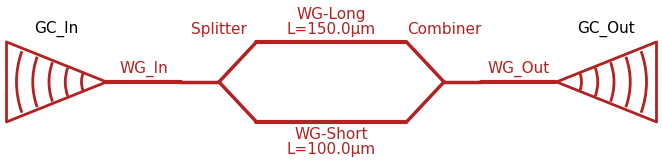

In [43]:
import schemdraw
import schemdraw.elements as elm
from schemdraw.segments import Segment, SegmentArc, SegmentText, SegmentPoly
import numpy as np

# --- Custom Elements ---

class OpticalSource(elm.Element):
    """ Circle with Lambda """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.segments.append(SegmentArc(center=(0,0), width=1.0, height=1.0, theta1=0, theta2=360))
        self.segments.append(SegmentText(pos=(0,0), label='$\\lambda$'))
        self.segments.append(Segment([(0.5, 0), (1.0, 0)])) 
        self.anchors['out'] = (1.0, 0)

class PhotonicSplitter(elm.Element):
    """ 
    1x2 Splitter 
    Anchors: 'p1' (Stem), 'p2' (Top Branch), 'p3' (Bot Branch)
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        L, H = 1.5, 0.8
        # Draw: Stem -> Y-junction -> Branches
        self.segments.append(Segment([(0,0), (L/2, 0)]))          # Stem
        self.segments.append(Segment([(L/2, 0), (L, H)]))        # Top Branch
        self.segments.append(Segment([(L/2, 0), (L, -H)]))       # Bot Branch
        
        # RENAMED ANCHORS TO AVOID 'in' KEYWORD
        self.anchors['p1'] = (0,0)   # Stem
        self.anchors['p2'] = (L, H)  # Top
        self.anchors['p3'] = (L, -H) # Bot
        
        self.params['lw'] = 2.5 
        self.params['color'] = 'firebrick' 

class GratingCoupler(elm.Element):
    """ 
    Focusing Grating Coupler 
    Geometry: Tip at (0,0) -> Expands to Base at (L, +/- W)
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        taper_len = 2.0
        width = 0.8
        
        # 1. Taper (Triangle)
        # Tip at (0,0), Wide end at (taper_len)
        poly_points = [(0, 0), (taper_len, width), (taper_len, -width), (0,0)]
        self.segments.append(SegmentPoly(poly_points, color='firebrick'))
        
        # 2. Curved Grating Lines (Near the wide end)
        for r in np.linspace(0.5, 1.8, 5):
            theta = 20
            self.segments.append(SegmentArc(center=(0,0), width=2*r, height=2*r, 
                                            theta1=-theta, theta2=theta, color='firebrick'))
            
        # Anchors
        self.anchors['waveguide'] = (0, 0)         # The Tip (connects to WG)
        self.anchors['grating']   = (taper_len, 0) # The Wide Body (connects to free space)

class OpticalProbe(elm.Element):
    """ Detector Box """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        w, h = 0.8, 0.8
        self.segments.append(SegmentPoly([(0, -h/2), (w, -h/2), (w, h/2), (0, h/2)], color='black'))
        self.segments.append(Segment([(0, -h/2), (w, h/2)], color='black')) 
        self.segments.append(Segment([(0, h/2), (w, -h/2)], color='black')) 
        self.anchors['in'] = (0,0)

# --- Drawing Routine ---

def get_wg_label(name, length):
    return f"{name}\nL={length}µm"

with schemdraw.Drawing() as d:
    d.config(fontsize=11, unit=2.5, inches_per_unit=0.5)

    # 1. Source
    #d.add(elm.Ground())
    #src = d.add(OpticalSource().label("Tunable\nLaser", loc='bottom'))
    
    # 2. Input GC
    # Orientation: Wide side (grating) faces Laser. Narrow side (waveguide) faces Circuit.
    # Default GC is Narrow(Left) -> Wide(Right).
    # We FLIP it to get Wide(Left) -> Narrow(Right).
    gc_in = d.add(GratingCoupler()
                  .reverse()
                  .anchor('grating') # Anchor the wide side...
                  #.at((src.out[0]+0.5, src.out[1])) # ...near the source
                  .label("GC_In"))
                  
    # 3. Input Waveguide
    # Connects to gc_in.waveguide (the tip, now on the right)
    wg_in = d.add(elm.Line().right().length(1.5).at(gc_in.waveguide)
                  .color('firebrick').linewidth(3)
                  .label("WG_In"))

    # 4. Splitter (Forward)
    # Anchor 'p1' (Stem) to the end of WG_In
    split = d.add(PhotonicSplitter().anchor('p1').at(wg_in.end).label("Splitter"))
    
    # 5. Arms
    # Top Arm (Long)
    arm_top = d.add(elm.Line().right().length(3).at(split.p2)
                    .color('firebrick').linewidth(3)
                    .label(get_wg_label("WG-Long", 150.0)))

    # Bottom Arm (Short)
    arm_bot = d.add(elm.Line().right().length(3).at(split.p3)
                    .color('firebrick').linewidth(3)
                    .label(get_wg_label("WG-Short", 100.0), loc='bottom'))

    # 6. Combiner (Flipped Splitter)
    # We want a Funnel shape (>). The Splitter is (<).
    # .flip() converts (<) to (>).
    # Anchors on Flipped Element: 'p2' (Top Branch) is now on the Left.
    comb = d.add(PhotonicSplitter()
                 .reverse()
                 .anchor('p2')       # Anchor the top input branch...
                 .at(arm_top.end)    # ...to the top arm
                 .label("Combiner"))

    # 7. Output Waveguide
    # Connects to comb.p1 (the Stem, which is now on the Right side)
    wg_out = d.add(elm.Line().right().length(1.5).at(comb.p1)
                   .color('firebrick').linewidth(3)
                   .label("WG_Out"))
    
    # 8. Output GC
    # Orientation: Narrow (waveguide) faces Circuit. Wide (grating) faces Detector.
    # Default GC is Narrow(Left) -> Wide(Right). This is perfect.
    gc_out = d.add(GratingCoupler()
                   .anchor('waveguide') # Anchor the tip...
                   .at(wg_out.end)      # ...to the WG
                   .label("GC_Out"))

    # 9. Detector
    # Place it near the wide grating output
    #d.add(OpticalProbe().at((gc_out.grating[0]+0.5, gc_out.grating[1])).anchor('in').label("Detector"))

--- DEMO: Photonic Splitter & Grating Link (Wavelength Sweep) ---
Sweeping Wavelength...
Solving for single wavelength (and jit compiling)
Compilation and single point simulation Time: 0.526s
Sweeping DC Operating Point...
Vmap simulation Time: 1.117s


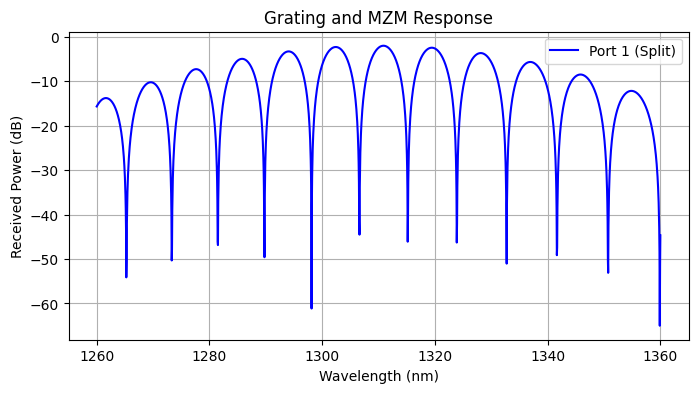

In [31]:
from circulus.photonic_components import Grating, OpticalWaveguide, Splitter, OpticalSource
print("--- DEMO: Photonic Splitter & Grating Link (Wavelength Sweep) ---")

models_map = {
    'grating': Grating,
    'waveguide': OpticalWaveguide,
    'splitter': Splitter,
    'source': OpticalSource,
    'resistor': Resistor,
    'ground': lambda: 0
}


groups, sys_size, port_map = compile_netlist(net_dict, models_map)

wavelengths = jnp.linspace(1260, 1360, 2000)

solver_strat = KLUSolver.from_circuit(groups, sys_size, is_complex=True)

print("Sweeping Wavelength...")
@jax.jit
def solve_for_loss(val):
    g = update_group_params(groups, 'grating', 'wavelength_nm', val)
    g = update_group_params(g, 'waveguide', 'wavelength_nm', val)
    y_flat = solver_strat.solve_dc(g, y_guess=jnp.ones(sys_size*2))
    return y_flat

start = time.time()
print("Solving for single wavelength (and jit compiling)")
solve_for_loss(1310)
total = time.time() - start
print(f"Compilation and single point simulation Time: {total:.3f}s")

print("Sweeping DC Operating Point...")
start = time.time()
solutions = jax.vmap(solve_for_loss)(wavelengths)
total = time.time() - start
print(f"Vmap simulation Time: {total:.3f}s")

v_out1 = solutions[:, port_map["Detector,p1"]] + 1j * solutions[:, port_map["Detector,p1"]+sys_size]
#v_out2 = solutions[:, port_map["Load2,p1" ]] + 1j * solutions[:, port_map["Load2,p1"]+sys_size]

p_out1_db = 10.0 * jnp.log10(jnp.abs(v_out1)**2 + 1e-12)
#p_out2_db = 10.0 * jnp.log10(jnp.abs(v_out2)**2 + 1e-12)

plt.figure(figsize=(8, 4))
plt.plot(wavelengths, p_out1_db, 'b-', label='Port 1 (Split)')
#plt.plot(wavelengths, p_out2_db, 'r--', label='Port 2 (Split)')

plt.title("Grating and MZM Response")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Received Power (dB)")
plt.legend()
plt.grid(True)
plt.show()